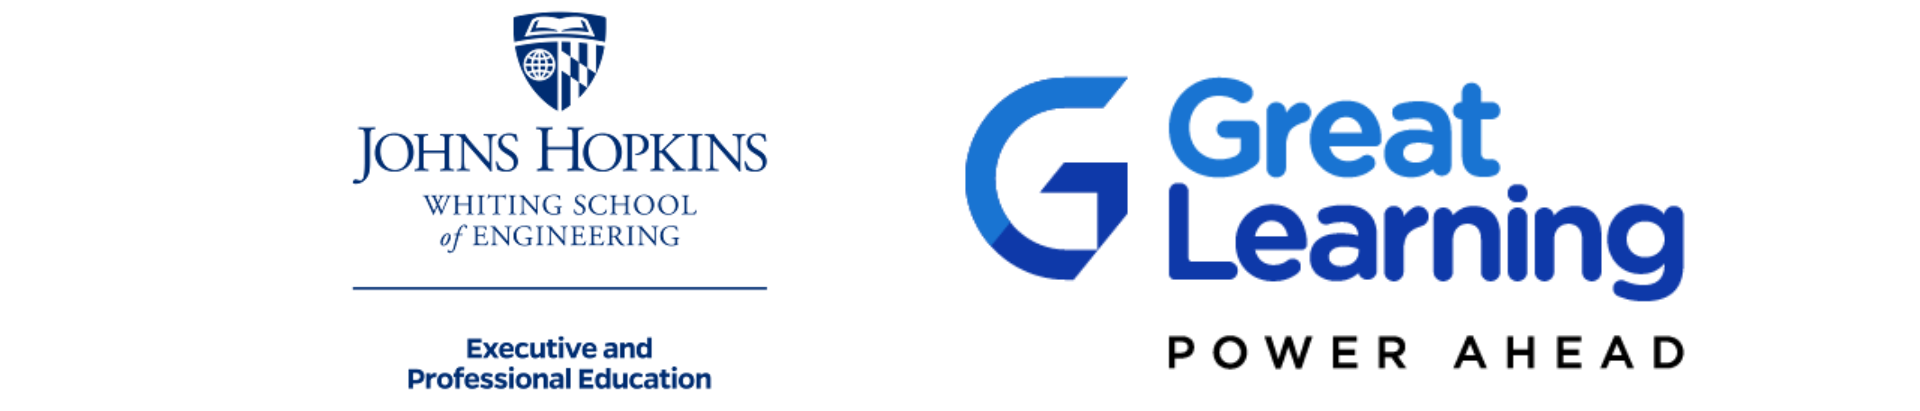

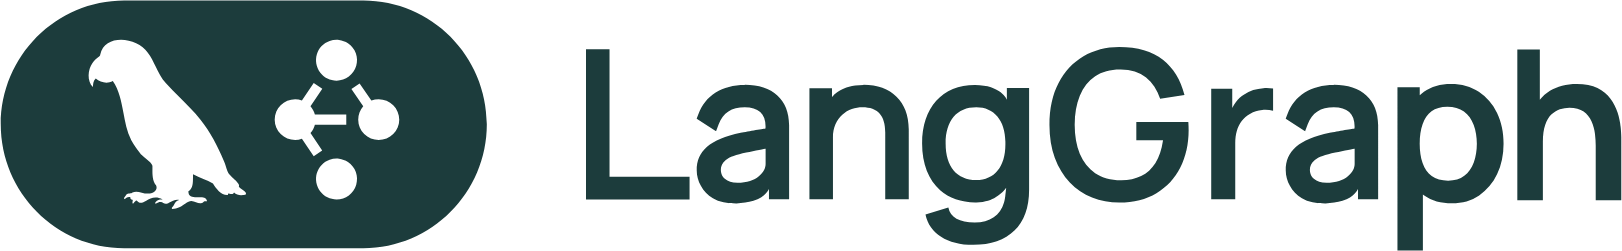

# Install and Import the Dependencies

In [27]:
!pip install langchain==0.3.27 \
                langchain-core==0.3.79 \
                langchain-openai==0.3.35 \
                chromadb==1.1.1 \
                langchain-community==0.3.31 \
                pypdf==5.4.0 \
                langgraph==0.6.6

# **1. Agentic RAG: Recursive Question Reframing + Generation**

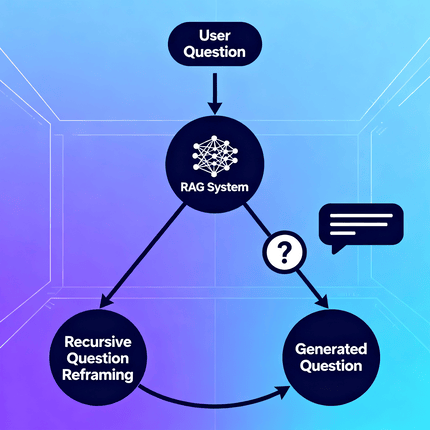



In this example, we demonstrate the LangGraph Framework's capability to create a dynamic, agentic workflow. The process showcases how the system can intelligently generate queries or responses, utilize tools for enhanced decision-making, retrieve relevant data, and refine questions through iterative rewriting. This highlights the framework's strength in managing complex, multi-step reasoning tasks with adaptability and efficiency.

### Components of Graph



- **generate_query_or_respond**: Decides whether to use tools (RAG) or respond directly.  
- **retrieve (ToolNode)**: Uses the retriever tool to fetch relevant context.  
- **grade_documents** (function): Evaluates the relevance of retrieved documents.  
- **rewrite_question**: Refines unclear or off-topic queries and restarts the cycle.  
- **generate_answer**: Produces the final, context-based answer.  

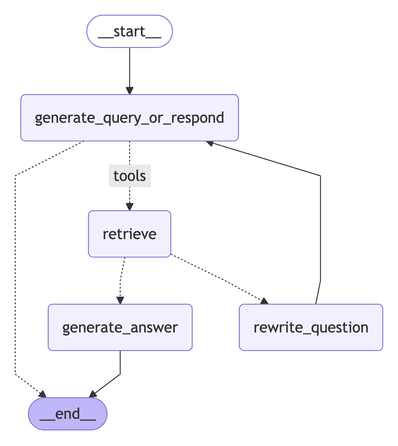


### Explanation of the Workflow Graph Nodes and Tools

This diagram illustrates how different nodes and tools in the workflow interact to process a user query efficiently.

1. **Start → generate_query_or_respond**  
   The workflow begins at the **`__start__`** node and moves to **`generate_query_or_respond`**.  
   This node receives the user’s query and decides whether the model should directly respond or use an external tool (RAG) to retrieve information.

2. **generate_query_or_respond → retrieve (tools path)**  
   If the model decides to use RAG, the process follows the **“tools”** path to the **`retrieve`** node.  
   Here, the **retriever tool** is activated to search the vector database (Chroma) for relevant research papers or document chunks related to the query.

3. **retrieve → generate_answer or rewrite_question**  
   After retrieval, the retrieved context is **graded for relevance** using the `grade_documents` function.  
   - If the context is **relevant**, the flow moves to the **`generate_answer`** node.  
   - If the context is **not relevant**, the flow moves to **`rewrite_question`**, where the question is reformulated for better clarity or focus.

4. **rewrite_question → generate_query_or_respond**  
   Once the question is rewritten, the process loops back to **`generate_query_or_respond`**, starting the decision process again—potentially leading to another retrieval attempt with the refined question.

5. **generate_answer → end**  
   When a relevant context is found, the **`generate_answer`** node uses the context and the user’s question to compose a concise, accurate answer.  
   After generating the response, the workflow transitions to the **`__end__`** node, completing the process.



Together, these nodes form an adaptive feedback loop that ensures each user query about **Agentic AI research papers** is handled efficiently—retrieving, evaluating, rewriting, and responding as needed.


In [28]:
# Importing Libraries
import json
import tiktoken

import pandas as pd

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma

##1.1 OpenAI Setup with LangChain

This script loads API credentials from `config.json` and sets them as environment variables.  
It then initializes a GPT model (`gpt-4o-mini`) via LangChain with controlled generation settings including temperature, token limit, top-p, frequency penalty, and stop sequences.


In [29]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [30]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

##1.2 Loading and Indexing Research Papers

First, the research papers are unzipped and the paths to all PDF files are collected.  
The PDFs are then loaded using `PyPDFDirectoryLoader`.  

In [31]:
# Unzipping the Research Papers
import zipfile
with zipfile.ZipFile("/content/agentic_ai_research_papers.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")

In [32]:
# Path of all reseach papers
research_paper_pdf_paths = [f"/content/agentic_ai_research_papers/{file}" for file in os.listdir("/content/agentic_ai_research_papers")]
research_paper_pdf_paths

['/content/agentic_ai_research_papers/AGENTIC_AI_FOR_SCIENTIFIC_DISCOVERY.pdf',
 '/content/agentic_ai_research_papers/Generative_to_Agentic_AI.pdf',
 '/content/agentic_ai_research_papers/AI_Agents_vs_Agentic_AI_A_Conceptual.pdf',
 '/content/agentic_ai_research_papers/The_role_of_agentic_AI_in_shaping_a_smart_future_A_systematic_review.pdf',
 '/content/agentic_ai_research_papers/AGI_via_Multi-Agent_Systems.pdf']

In [33]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(path = "/content/agentic_ai_research_papers/")

The text is split into overlapping chunks to preserve context.  

In [34]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=1000,
    chunk_overlap=200
)

In [35]:
research_papers_chunks = loader.load_and_split(text_splitter)

Embeddings for each chunk are generated using the `text-embedding-ada-002` model.

In [36]:
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002')

Finally, the embeddings are stored in a Chroma vector store, and a retriever is created to enable similarity-based search over the documents.

In [37]:
vectorstore = Chroma.from_documents(
    research_papers_chunks,
    embedding_model,
    collection_name="Research_Papers"
)

##1.3 Tool: `retrieve_scientific_papers`

The Chroma vector store is converted into a retriever that performs similarity-based searches, retrieving the top 10 most relevant chunks for a given query.  

A LangChain retriever tool is then created using this retriever. The tool is named `retrieve_scientific_papers` and is described as a utility to search and return information from scientific research papers. There are numerous Langchain Tools available at bay for use. Follow [LangChain Tools](https://https://python.langchain.com/docs/integrations/tools/) dor detailed information.


In [38]:
retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 3}
)

In [39]:
# creating a retriever tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_scientific_papers",
    "Contains detailed Research Outcomes on AgenticAI research Papers",
)


Once set up, the tool can be invoked with a query, for example `"Aspects of Agentic AI System"`, and it will return the most relevant information from the indexed research papers, enabling efficient document-based question answering.

In [40]:
retriever_tool.invoke({"query": "Aspects of Agentic AI System"})

'(2024) employs multiple workers handling parts of a task (sequentially) and a\nmanager aggregating results.\n• Learning: Agents may learn independently in decentralized systems or share\nexperiences centrally to accelerate collective improvement.\n• Communication content: Communication is primarily text-based; coopera-\ntive systems often package instructions, goals, state descriptions, action histories,\nand dialogue histories into messages (Zhang et al., 2023). Agentic systems often\nmimic real-world development by featuring domain-expert agents that collaborate\nthrough discussions, potentially adopting varied communication styles (Yamamoto\net al., 2025).\n3.5.3 Evaluating Agentic AI\nEvaluating Agentic AI is challenging. Agents can behave non-deterministic with com-\nplex interactions and require a much longer time-span to complete tasks than GenAI.\nAgents can exhibit a wide range of capabilities and desiderata that require evaluation.\nWe outline key decision domains but refer 

##1.4 Node-1: `generate_query_or_respond`
This node generates responses based on the current conversation state using the generate_query_or_respond function. It takes a MessagesState (chat history), uses the bound llm and retriever_tool to decide whether to fetch data or reply directly, and returns the model’s response as an updated message state.


In [41]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = ( llm.bind_tools([retriever_tool]).invoke(state["messages"]) )
    return {"messages": [response]}


When the message `Hi!` is provided and no relevant tool interaction is needed, the LLM directly responds with an AI message: `Hello! How can I assist you today?`

In [42]:
# Test Case
input = {"messages": [{"role": "user", "content": "Hi!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In this example, the user asks a specific question: `"What are the key aspects of an Agentic AI systems?"`.  

The input message is passed to the `generate_query_or_respond` function. The language model evaluates the query and decides whether to retrieve relevant information from the research papers or respond directly.  

The response is printed and we see that an invocation to the tool was made by the LLM.


In [43]:
# Test Case
input = {
    "messages": [
        {
            "role": "user",
            "content": "What are the key aspects of an Agentic AI systems?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_scientific_papers (call_0EESMNiic2Tf9Oz0S7uyjNtm)
 Call ID: call_0EESMNiic2Tf9Oz0S7uyjNtm
  Args:
    query: key aspects of Agentic AI systems


##1.5 Function: `grade_documents`
This function acts as a decision point in the workflow, determining the next step based on the relevance of retrieved documents.  

The `GRADE_PROMPT` instructs the model to check if the retrieved content is semantically related to the user’s question and return a binary score — `"yes"` for relevant or `"no"` for not relevant.  

Using the `GradeDocuments` schema for structured output, the `grade_documents` function evaluates the context and decides the workflow’s next node:  
- Returns **`"generate_answer"`** if the document is relevant.  
- Returns **`"rewrite_question"`** if it is not.  

This conditional branching ensures that only relevant content is used for answer generation, while unclear or off-topic queries are refined before reprocessing.



In [44]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are evaluating whether a retrieved document is relevant to a user question.\n\n"
    "Document:\n{context}\n\n"
    "Question:\n{question}\n\n"
    "Consider relevance in terms of concepts and topics that naturally relate to the subject matter of the question. "
    "Give a clear 'yes' if the document meaningfully contributes to answering the question, or 'no' if it does not."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = llm


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

### Evaluating Relevance of Retrieved Research Paper Information

This code tests the `grade_documents` function to assess how well it determines relevance.  

In the example, the user asks for the titles of actual research papers, but the retrieved tool output is simply `"meow"`, which is unrelated. The grader correctly identifies this as **not relevant** and would prompt a question rewrite.  


In [45]:
# Test Case Evaluation shown that question is not related to the content and needs to be rewritten, hence it showns "rewrite_question"

from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "List down all the 5 titles of the actual research papers and not the refrence research papers",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_scientific_papers",
                        "args": {"query": "Who is the writer of the paper"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

##1.6 Node-2: `rewrite_question`

The **`rewrite_question`** node is responsible for refining unclear or ambiguous user inputs to improve the overall accuracy of retrieval and response generation.  

It uses the `REWRITE_PROMPT` to analyze the user’s original query, identify its intent, and reformulate it into a clearer and more specific version — focusing on original research papers related to Agentic AI rather than reference works.  

This node extracts the question from the conversation state, formats it into the prompt, and invokes the language model. The refined question is then passed back into the workflow, enabling a more precise retrieval and answer-generation cycle.


In [46]:
REWRITE_PROMPT = """
You are an assistant that rewrites user questions to be strictly about Agentic AI and related concepts (agents, AI systems, multi-agent intelligence, or AI research).
If the question is off-topic or vague, transform it into a clear, focused, and answerable question within this theme.
Output only the rewritten question—no explanations, no extra words.

Original Question: {question}
Rewritten Question:
"""


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In this test, the user’s original question is:  
*"List down all the 5 titles of the actual research papers and not the reference research papers."*  

The context shows that the assistant had previously attempted to use the retriever tool with the query *"Who is the writer of the paper"*, and the tool returned the irrelevant response `"meow"`. This indicates that the model misunderstood the user’s intent.  

The `rewrite_question` function is applied to this input to improve clarity. It analyzes the original query, detects that the user wants only the **titles of the main research papers** (excluding reference papers), and reformulates the question to make that intent explicit.  

The refined version, printed as output, represents a clearer and more direct query for the retrieval system to handle accurately.

In [47]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "List down all the 5 titles of the actual research papers and not the refrence research papers",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_scientific_papers",
                        "args": {"query": "Who is the writer of the paper"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the titles of five recent research papers specifically focused on Agentic AI and multi-agent intelligence?


##1.7 Node-3: `generate_answer` – Generating Final Responses from Retrieved Context

The **`generate_answer`** node produces the final answer by combining the user’s question with the retrieved context.  

It uses the `GENERATE_PROMPT`, which instructs the model to provide a short, clear response (up to three sentences) based strictly on the retrieved material. If sufficient information is not available, the model explicitly states that it does not know the answer.  

Within this node, the function extracts both the question and the context from the message state, formats them into the prompt, and invokes the language model. The resulting message contains the final, context-driven response.  

This node marks the completion of the retrieval and reasoning process, ensuring that the user receives an accurate, concise, and well-grounded answer before the workflow transitions to the end state.


In [48]:
GENERATE_PROMPT = """
You are an assistant whose task is to review the provided context and answer the user's question.
Answer the question based only on this context and do not mention the context itself.
If the answer is not found in the context, respond "I don't know".
Keep your answer concise, using a maximum of three sentences.

Question: {question}
Context: {context}
"""



def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

##1.8 Compiling the RAG-Based QA Workflow Graph

This workflow, built with **LangGraph**, adapts to decide when to retrieve, rewrite, or answer queries using a **`StateGraph`** based on `MessagesState`.

### Nodes
- **`generate_query_or_respond`** – Entry point; decides to answer or retrieve.  
- **`retrieve` (ToolNode)** – Fetches relevant research chunks from the vector store. The **ToolNode** can host multiple tools beyond retrieval, such as summarizers, citation extractors, or specialized processors, allowing the agent to act on various data sources dynamically.  
- **`rewrite_question`** – Clarifies unclear queries.  
- **`generate_answer`** – Produces the final response using the question and retrieved context.  

### Logic
- Starts at `generate_query_or_respond`.  
- **Direct edge** → `retrieve` if needed; else answer directly.  
- **Conditional edge** via `grade_documents`:  
  - **Relevant** → `generate_answer`.  
  - **Not relevant** → `rewrite_question` → loops back.  
- Edges connect `rewrite_question` back to start and `generate_answer` to end.

### Compilation
The graph is compiled into a self-correcting QA pipeline, ensuring accurate, context-aware answers on Agentic AI research.


In [49]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

##1.9 Visualizing the Workflow Graph

The workflow is visualized to clarify node interactions and logic.  

A Mermaid diagram is generated with `graph.get_graph().draw_mermaid_png()` and displayed in the notebook using `IPython.display.Image` and `display`.  

This visualization highlights how query generation, retrieval, grading, rewriting, and answer generation connect, helping verify the workflow aligns with the intended QA process.


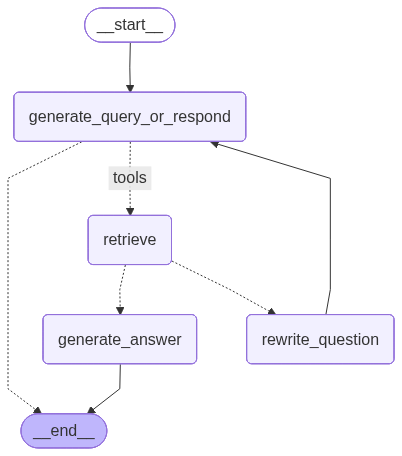

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

##1.10 Executing the Workflow with User Queries

In this section, the complete workflow is tested using actual user queries.  

The workflow can be executed synchronously using `graph.invoke()`, which runs the entire workflow from start to finish and returns the final output. The input consists of the user’s query, and the workflow handles all stages: retrieving relevant documents, grading them, rewriting questions if necessary, and generating answers.  

Once the workflow finishes, the resulting messages are displayed using `pretty_print()`, providing a clear view of the final response. This approach simplifies execution when intermediate node updates are not needed and focuses on the final output produced for the user query.


In [51]:
# Prepare the input
input_data = {
    "messages": [
        {
            "role": "user",
            "content": "Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions`",
        }
    ]
}

# Run the workflow and get the final result
result = graph.invoke(input_data)

# Print the final messages
for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions`
================================== Ai Message ==================================
Tool Calls:
  retrieve_scientific_papers (call_o42S2Qf7g6qZqAAjwebusENX)
 Call ID: call_o42S2Qf7g6qZqAAjwebusENX
  Args:
    query: Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions
================================= Tool Message =================================
Name: retrieve_scientific_papers

Published as a conference paper at ICLR 2025
AGENTIC AI FOR SCIENTIFIC DISCOVERY : A S URVEY
OF PROGRESS , C HALLENGES , AND FUTURE DIREC -
TIONS
Mourad Gridach, Jay Nanavati, Khaldoun Zine El Abidine, Lenon Mendes & Christina Mack
IQVIA
{firstname.lastname}@iqvia.com
ABSTRACT
The integration of Agentic AI into scientific discovery marks a new frontier in
researc

In [52]:
# Prepare the input
input_data = {
    "messages": [
        {
            "role": "user",
            "content": "Give me the names of cloud research papers.",
        }
    ]
}

# Run the workflow and get the final result
result = graph.invoke(input_data)

# Print the final messages
for message in result["messages"]:
      message.pretty_print()

================================ Human Message =================================

Give me the names of cloud research papers.
================================== Ai Message ==================================
Tool Calls:
  retrieve_scientific_papers (call_W4U5dYXDyFPFdCIGaaVYcZ0C)
 Call ID: call_W4U5dYXDyFPFdCIGaaVYcZ0C
  Args:
    query: cloud
================================= Tool Message =================================
Name: retrieve_scientific_papers

pher Hesse, Shantanu Jain, Vineet Kosaraju, William Saunders, et al. Webgpt: Browser-assisted
question-answering with human feedback. arXiv preprint arXiv:2112.09332, 2021.
Ziqi Ni, Yahao Li, Kaijia Hu, Kunyuan Han, Ming Xu, Xingyu Chen, Fengqi Liu, Yicong Ye,
and Shuxin Bai. Matpilot: an llm-enabled ai materials scientist under the framework of human-
machine collaboration. arXiv preprint arXiv:2411.08063, 2024.
Kolby Nottingham, Prithviraj Ammanabrolu, Alane Suhr, Yejin Choi, Hannaneh Hajishirzi, Sameer
Singh, and Roy Fox. Do embodi

## Conclusion

1) LangGraph is not a completely new framework; it is built on top of LangChain to extend its capabilities. It can utilize existing LangChain tools and incorporate them directly into graph structures, making it easier to design complex workflows and logic in a visual and programmatic way.

2) In our demonstration, we explored tools with conditional branching and other features within LangGraph. However, LangGraph offers even more advanced functionalities, such as Multi-Chain Processing (MCP) and multi-agent orchestration, which we plan to explore in the upcoming sessions. These features can significantly enhance automation and decision-making in complex pipelines.

3) From the examples we worked through, it is evident that LangGraph simplifies the management of RAG workflows. We did not need to manually monitor the relevance between the RAG content and the user question. The system automatically refined the questions and generated suitable answers, streamlining the overall process and reducing the need for manual intervention.
